In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(1, r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning')

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
import FunctionCollection as fc
import importlib
import quadpy
from scipy.special import erf
from scipy.integrate import quad_vec
import sympy
fc = importlib.reload(fc)
from tqdm import tqdm
from scipy.stats import norm

In [2]:
plt.rcParams.update({'font.size': 15})

In [37]:
pred_path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\predictions'
df = pd.read_csv(os.path.join(pred_path,'OscNext_Angle_m27_23ge_test_predictions.csv'))
df = df.sort_values(by='event_no').reset_index()

In [38]:
df

,index,Unnamed: 0,event_no,azimuth,zenith,energy_log10,pid,elasticity,azimuth_pred,zenith_pred,pred_sigma
0,1266688,1266688,8.0,3.792724,1.480126,0.502466,-14.0,0.502466,3.951125,1.453015,0.788486
1,1073152,1073152,10.0,5.647645,2.365463,0.614953,14.0,0.614953,8.727803,1.427517,0.938153
2,519168,519168,15.0,1.259284,1.690406,0.537057,14.0,0.537057,7.503609,2.183466,0.727186
3,733184,733184,29.0,0.199578,2.857227,0.308843,-14.0,0.308843,2.704682,2.584966,1.508280
4,985088,985088,32.0,4.078112,1.935199,0.617130,14.0,0.617130,2.522883,1.796655,0.737616
...,...,...,...,...,...,...,...,...,...,...,...
1658357,23551,23551,117104746.0,6.013144,1.001607,2.398728,13.0,2.398728,5.735962,0.825702,0.550487
1658358,28670,28670,117104747.0,5.256122,1.097556,2.340758,13.0,2.340758,6.365918,0.327791,1.097434
1658359,28671,28671,117104750.0,4.385466,0.922474,2.366642,13.0,2.366642,4.409213,0.159849,1.401383
1658360,17407,17407,117104752.0,1.586383,0.957551,2.389911,13.0,2.389911,6.683097,0.773901,1.252674


In [34]:
stats = pd.read_csv(os.path.join(pred_path,'stats.csv'))

In [35]:
stats

,Unnamed: 0,event_no,n_strings,n_doms,cq_x,cq_y,cq_z
0,0,8,7.0,11,29.560598,-28.549552,-346.532387
1,1,10,7.0,16,60.860462,-58.746769,-388.543386
2,2,15,5.0,17,33.878788,-11.369393,-323.135152
3,3,29,3.0,9,103.089133,-87.221304,-439.446528
4,4,32,3.0,18,-2.941875,-80.715625,-303.853742
...,...,...,...,...,...,...,...
1658357,1658357,117104746,4.0,18,124.479744,-10.813078,-195.591284
1658358,1658358,117104747,6.0,12,78.500268,-21.699200,-452.746801
1658359,1658359,117104750,7.0,14,14.253714,-70.891714,-372.580001
1658360,1658360,117104752,4.0,17,63.498789,27.282728,-242.018026


In [43]:
def plot_quantiles(res, x, bins, qs, ax, label, color,offset):
    slices = np.linspace(x.min(),x.max(),bins + 1)
    quantiles = np.zeros((bins,len(qs)))
    xes = np.zeros(bins)
    
    for i in range(bins):
        mask = (x >= slices[i])&(x <= slices[i+1])
        if mask.sum() != 0:
            quantiles[i] = np.quantile(res[mask],qs)
            xes[i] = np.mean(x[mask])
        else:
            print('whoops',i)
            quantiles[i] = None
            xes[i] = None
    
    xes += offset
    
    ax.errorbar(x = xes, y = quantiles[:,1], yerr = abs(quantiles[:,1] - quantiles[:,[0,2]].T),
                color=color,
                linewidth=5,
                alpha=0.5,
                capsize=5,
                linestyle='--',
                fmt='none')
    
    ax.plot(xes,quantiles[:,1],c=color,marker='*',label=label)
#     plt.grid()
    
    ax_hist = ax.twinx()
    val, binedges, _ = ax_hist.hist(x,bins=bins,histtype='step',color='grey',linewidth=5)
    ax_hist.vlines(xes-offset,val+0.1*val.mean(),val-0.1*val.mean(),color='grey',label='mean')
    ax_hist.set_ylim(0,ax_hist.get_ylim()[1])
    ax_hist.set_ylabel("N")
#     ax_hist.set_yscale('log')
    ax.set_zorder(ax_hist.get_zorder()+1)
    ax.patch.set_visible(False)

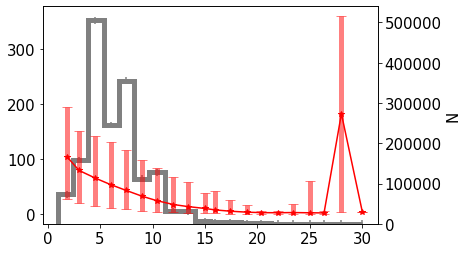

In [53]:
fig, ax = plt.subplots()
plot_quantiles((df.azimuth_pred - df.azimuth).abs()*180/np.pi,stats.n_strings,20,[0.16,0.5,0.68],ax,'ok','r',0)